# Demo de implementación de un Algoritmo Genético para resolver el problema de encontrar un vector de números que maximiza la suma de sus valores (es decir, que complete toda la lista con los números más grandes permitidos)
Utiliza la librería DEAP disponible en https://deap.readthedocs.io/en/master/

In [1]:
#@title Instalar librerías
!pip install deap

# instala paquetes gráficos
!apt-get install -y graphviz-dev
!pip install pygraphviz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 4.5 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Note, selecting 'libgraphviz-dev' instead of 'graphviz-dev'
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common libgvc6-plugins-gtk
  librsvg2-common libxdot4
Suggested packages:
  gvfs
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk librsvg2-common libxdot4
0 upgraded, 9 newly installed, 0 to remove and 20 not upgraded.
Need to get 2,434 kB of archives.
After this operation, 7,681 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgtk2.0-common all 2.24.33-2ubuntu2.1 [125 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgtk2.0-0 amd64 2.24.33-2ubuntu2.1 [2,03

In [2]:
#@title Cargar Librerías
import random
import numpy as np
import math

from deap import base
from deap import creator
from deap import tools

import matplotlib
import matplotlib.pyplot as plt
import networkx
from IPython.display import display
from PIL import Image

print("\nLibrerías importadas")


Librerías importadas


In [3]:
#@title PARÁMETROS DE LA CORRIDA

# Cantidad de Ciclos de la Corrida
CANT_CICLOS = 100  #@param {type:"integer"}

# Indica que finaliza corrida cuando se alcance una  Aptitud Mínima (opcional)
FINALIZA_CORRIDA_POR_APTITUD = True  #@param {type:"boolean"}

# Cantidad de Individuos en la Población
CANT_INDIVIDUOS_POBLACION = 15 #@param {type:"integer"}
if CANT_INDIVIDUOS_POBLACION < 5:
  CANT_INDIVIDUOS_POBLACION = 5

print("\nParámetros de la Corrida definidos")


Parámetros de la Corrida definidos


In [4]:
#@title FUNCIÓN DE APTITUD Y ESTRUCTURA DEL CROMOSOMA

#@markdown > Función de Aptitud:
#@markdown - indica que es para maximizar.
#@markdown - determina la aptitud como la suma de los valores del cromosoma de cada individuo.

## Inicializa objeto Toolbox auxiliar
toolbox = base.Toolbox()

# indica que es la función de aptitud es para maximizar
creator.create("Fitness", base.Fitness, weights=(1.0,))

# definimos la función de aptitud
def funcAptitud(individual):
    return sum(individual),

# registra la función que se va a evaluar
toolbox.register("evaluate", funcAptitud)

print("\nFunción de Aptitud definida")


#@markdown > Estructura del Cromosoma:
#@markdown - indica que es una lista de valores enteros con valores de o "valorMax_genesCromosomas" del largo definido en el parámetro "cant_genesCromosoma".

# valor máximo de los genes
valorMax_genesCromosomas = 1 #@param {type:"integer"}
if valorMax_genesCromosomas < 1:
  valorMax_genesCromosomas = 1
# cantidad de genes que va a tener el cromosoma
cant_genesCromosoma =  7 #@param {type:"integer"}
if cant_genesCromosoma < 2:
  cant_genesCromosoma = 2
FINALIZA_CORRIDA_VAL_MIN_APTITUD = cant_genesCromosoma

# indica que los individuos son una lista de genes que aplica la función antes definida
creator.create("Individual", list, fitness=creator.Fitness)

# indica que los genes son binarios ( 0 / 1 )
toolbox.register("attr_bin", random.randint, 0, valorMax_genesCromosomas)

# registra el tipo de individuo y población a usar
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bin, cant_genesCromosoma)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Determina mínima Heuristica para finalizar el algoritmo
MIN_HEURISTICA_FINALIZAR = cant_genesCromosoma*valorMax_genesCromosomas

print("\nCromosoma definido")


Función de Aptitud definida

Cromosoma definido


In [5]:
#@title OPERADORES GENÉTICOS
#@markdown definidos  en https://deap.readthedocs.io/en/master/api/tools.html#operators

tipo_seleccion = 'Torneo' #@param ["Azar", "Torneo", "Ranking", "Ruleta"]
tipo_cruzamiento = 'Simple-1Punto' #@param ["Simple-1Punto", "Simple-2Puntos", "Azar"]

# Probabilidad del Mutación
probab_mutacion = 0.5 #@param {type:"slider", min:0, max:1, step:0.05}

# Registrar tipo de Selección a aplicar con sus parámetros
if tipo_seleccion == 'Torneo':
  toolbox.register("select", tools.selTournament, tournsize=2)
elif tipo_seleccion == 'Ranking':
  toolbox.register("select", tools.selBest)
elif tipo_seleccion == 'Ruleta':
  toolbox.register("select", tools.selRoulette)
else:
  toolbox.register("select", tools.selRandom)

# Registrar tipo de Cruzamiento a aplicar con sus parámetros
if tipo_cruzamiento == 'Simple-1Punto':
  toolbox.register("mate", tools.cxOnePoint)
elif tipo_cruzamiento == 'Simple-2Puntos':
  toolbox.register("mate",  tools.cxTwoPoint)
else:
  toolbox.register("mate", tools.cxUniform, indpb=10/cant_genesCromosoma)

# Registrar tipo de Mutación a aplicar con sus parámetros
toolbox.register("mutate", tools.mutUniformInt, low=0, up=valorMax_genesCromosomas, indpb=10/cant_genesCromosoma)

print("\nOperadores Genéticos definidos")


Operadores Genéticos definidos


4) Ejecutar la corrida del algoritmo mostrando resultados:

In [6]:
#@title FUNCIONES AUXILIARES

## Define una función auxiliar para calcular estadísticas y guarda info en vectores auxiliares
def CalculoEstadisticas(ciclo, indivPobla, muestra, mejorMax = True):
    global mejorIndCorrida, mejorIndCorrida_ciclo
    global ciclosMaxAptitud
    global ciclosPromAptitud
    global ciclosMinAptitud
    if len(indivPobla) == 0:
      return None, 0, 0, 0
    auxMax = None
    auxMin = None
    auxSum = 0
    auxBestInd = None
    auxBestIndApt = None
    for ind in indivPobla:
        apt = round(ind.fitness.values[0], 2)
        auxSum = auxSum + apt
        if (auxMax == None) or (apt > auxMax):
            auxMax = apt
            if mejorMax:
              auxBestInd = ind
              auxBestIndApt = apt
        if (auxMin == None) or (apt < auxMin):
            auxMin = apt
            if not mejorMax:
              auxBestInd = ind
              auxBestIndApt = apt
    auxProm = round(auxSum / len(indivPobla), 2)
    if mejorMax:
      if (mejorIndCorrida == None) or (mejorIndCorrida.fitness.values < auxBestInd.fitness.values):
            mejorIndCorrida = auxBestInd
            mejorIndCorrida_ciclo = ciclo
    else:
      if (mejorIndCorrida == None) or (mejorIndCorrida.fitness.values > auxBestInd.fitness.values):
            mejorIndCorrida = auxBestInd
            mejorIndCorrida_ciclo = ciclo
    ciclosMaxAptitud.append( auxMax )
    ciclosPromAptitud.append( auxProm )
    ciclosMinAptitud.append( auxMin )
    if muestra:
        #print("\n-- Ciclo  %i --" % ciclo)
        print(" ++ Mejor Individuo:", auxBestInd, " {", auxBestIndApt, "}")
        print("      Max: ", auxMax, " / Promedio: ", auxProm, " / Min: ", auxMin)
    return auxBestInd, auxMax, auxProm, auxMin

def asignarAptitud(indivPobla):
  # Asigna el valor de aptitud a los individuos
  fitnesses = list(map(toolbox.evaluate, indivPobla))
  for ind, fit in zip(indivPobla, fitnesses):
      ind.fitness.values = fit


def mostrarParamsDetalle():
  print("EJECUCIÓN DE LA CORRIDA: ")
  print("\t Criterio de Paro: "+str(CANT_CICLOS)+" ciclos"+(", o si llega a la solución" if FINALIZA_CORRIDA_POR_APTITUD else "")+".")
  print("\t Tamaño de la Población: "+str(CANT_INDIVIDUOS_POBLACION)+" individuos.")
  print("\t Método de Selección: "+tipo_seleccion+".")
  print("\t Método de Cruzamiento: "+tipo_cruzamiento+".")
  print("\t Método de Mutación: Simple con "+str(probab_mutacion*100)+"% de probabilidad.")
  print("")

def mostrarPoblaDetalle(indivPobla, titulo=""):
  if titulo != "":
    print("\n" + titulo)
  for ind in indivPobla:
    print("\t", ind, " { ", ind.fitness.values[0], " } ")
  print("")

print("\nFunciones auxiliares definidas")


Funciones auxiliares definidas


In [7]:
#@title EJECUCIÓN DE LA CORRIDA

# Indica si se muestra el detalle de los operadores genéticos aplicados
MOSTRAR_DETALLE = True #@param {type:"boolean"}

# Indica si se muestra el detalle de las estadísticas en cada ciclo
MUESTRA_ESTADISTICAS = True  #@param {type:"boolean"}

if MOSTRAR_DETALLE:
  mostrarParamsDetalle()

# Resetear Genelogy
history = tools.History()
# Decorate the variation operators
toolbox.decorate("mate", history.decorator)
toolbox.decorate("mutate", history.decorator)

# cálcula cantidad de individuos seleccionados como la mitad + 1
cant_ind_selecc = (CANT_INDIVIDUOS_POBLACION//2)+1

# Define la población inicial
indivPobla = toolbox.population(n=CANT_INDIVIDUOS_POBLACION)
history.update(indivPobla)

# Asigna el valor de aptitud a los individuos de la población inicial
asignarAptitud(indivPobla)

if MOSTRAR_DETALLE or MUESTRA_ESTADISTICAS:
  print("\n-- Ciclo  0 --")

if MOSTRAR_DETALLE:
  mostrarPoblaDetalle(indivPobla, "*) Población Inicial:")

# vectores auxiliares
ciclo = 1
mejorIndCorrida = None
mejorIndCorrida_ciclo = 0
ciclosIndiv = []
ciclosMaxAptitud = []
ciclosPromAptitud = []
ciclosMinAptitud = []


# Cálcula estadísticas y guarda info en vectores auxiliares
auxBestInd, auxMax, auxProm, auxMin = CalculoEstadisticas(0, indivPobla, MUESTRA_ESTADISTICAS)

        # criterio de paro
while (ciclo < CANT_CICLOS) \
  and (not(FINALIZA_CORRIDA_POR_APTITUD) or (mejorIndCorrida==None) or (mejorIndCorrida.fitness.values[0]<MIN_HEURISTICA_FINALIZAR)):

    if MOSTRAR_DETALLE or MUESTRA_ESTADISTICAS:
      print("\n-- Ciclo  %i --" % ciclo)

    # Realiza la Selección
    indivSelecc = toolbox.select(indivPobla, cant_ind_selecc)
    if MOSTRAR_DETALLE:
      mostrarPoblaDetalle(indivSelecc, "a) Individuos Seleccionados:")

    # Realiza el Cruzamiento
    # por cada individuo seleccionado los clona (sino pueden afectarle los cambios)
    # y luego le busca una pareja al azar dentro de los seleccionados para generar 2 hijos
    if MOSTRAR_DETALLE:
      print("b) Cruzamiento: ")
    indivHijos = []
    for hijo1 in list(map(toolbox.clone, indivSelecc)):
      if len(indivHijos) < len(indivPobla):
        # todavía falta generar hijos
        hijo2 = list(map(toolbox.clone, random.sample(indivSelecc, 1)))[0]
        if MOSTRAR_DETALLE:
          print("\t", hijo1, "x", hijo2, end=" =")
        # hace el cruzamiento
        toolbox.mate(hijo1, hijo2)
        del hijo1.fitness.values
        del hijo2.fitness.values
        # agrega 1er hijo
        indivHijos.append(hijo1)
        if MOSTRAR_DETALLE:
          print("", hijo1, end="")
        if len(indivHijos) < len(indivPobla):
          # agrega 2do hijo
          indivHijos.append(hijo2)
          if MOSTRAR_DETALLE:
            print(" &", hijo2, end="")
        if MOSTRAR_DETALLE:
          print("")
      else:
        break

    # controla que mantenga que los hijos
    # tenga la misma cantidad de individuos que la población original
    if len(indivHijos) != len(indivPobla):
      print("ERROR: distinta cantidad de individuos hijos ", len(indivHijos) , " | ", len(indivPobla))

    # Realiza la Mutación
    if MOSTRAR_DETALLE:
      print("\nc) Mutación: ")
    if random.random() < probab_mutacion:
      # ejecuta mutación:
      # selecciona al azar el individuo a mutar
      # y lo muta aplicando el método
      mutant = indivHijos[random.randint(0, len(indivHijos)-1)]
      if MOSTRAR_DETALLE:
        print("\tse ejecuta: ", mutant, end=" ")
      # hace la mutación
      toolbox.mutate(mutant)
      del mutant.fitness.values
      if MOSTRAR_DETALLE:
        print("--> ", mutant, "\n")
    else:
      # no se ejecuta mutación
      print("\tNo se ejecuta\n")

    # Evalua a los individuos hijos que salen de Cruzamiento & Mutación
    #  para determinar si son válidos y su valor de aptitud
    invalid_ind = [ind for ind in indivHijos if not ind.fitness.valid]
    asignarAptitud(invalid_ind)

    # Reemplaza la población actual con los hijos
    indivPobla[:] = indivHijos
    if MOSTRAR_DETALLE:
      mostrarPoblaDetalle(indivPobla, "*) Siguiente Generación:")

    # Cálcula estadísticas y guarda info en vectores auxiliares
    auxBestInd, auxMax, auxProm, auxMin = CalculoEstadisticas(ciclo, indivPobla, MUESTRA_ESTADISTICAS)

    ciclo = ciclo + 1

print("\n-- Corrida Finalizada en %i ciclos --" % ciclo )
print("== Mejor Individuo de la Corrida aparece en ciclo ", mejorIndCorrida_ciclo, ":", mejorIndCorrida, " { ", round(mejorIndCorrida.fitness.values[0], 3), " }  ==")

EJECUCIÓN DE LA CORRIDA: 
	 Criterio de Paro: 100 ciclos, o si llega a la solución.
	 Tamaño de la Población: 15 individuos.
	 Método de Selección: Torneo.
	 Método de Cruzamiento: Simple-1Punto.
	 Método de Mutación: Simple con 50.0% de probabilidad.


-- Ciclo  0 --

*) Población Inicial:
	 [0, 0, 0, 0, 1, 1, 1]  {  3.0  } 
	 [1, 0, 1, 1, 0, 0, 1]  {  4.0  } 
	 [0, 1, 1, 0, 0, 0, 0]  {  2.0  } 
	 [1, 0, 1, 0, 0, 0, 0]  {  2.0  } 
	 [0, 1, 1, 0, 1, 0, 0]  {  3.0  } 
	 [1, 1, 1, 1, 1, 0, 1]  {  6.0  } 
	 [0, 0, 0, 1, 0, 1, 0]  {  2.0  } 
	 [1, 1, 0, 1, 0, 1, 1]  {  5.0  } 
	 [1, 1, 1, 1, 1, 1, 0]  {  6.0  } 
	 [0, 0, 0, 1, 1, 0, 0]  {  2.0  } 
	 [0, 1, 1, 1, 0, 1, 0]  {  4.0  } 
	 [0, 0, 1, 0, 1, 1, 1]  {  4.0  } 
	 [0, 1, 1, 0, 0, 1, 1]  {  4.0  } 
	 [0, 1, 0, 0, 1, 0, 1]  {  3.0  } 
	 [0, 0, 1, 1, 0, 1, 0]  {  3.0  } 

 ++ Mejor Individuo: [1, 1, 1, 1, 1, 0, 1]  { 6.0 }
      Max:  6.0  / Promedio:  3.53  / Min:  2.0

-- Ciclo  1 --

a) Individuos Seleccionados:
	 [1, 0, 1, 1, 0, 0, 

5) Generar gráficos de la corrida:

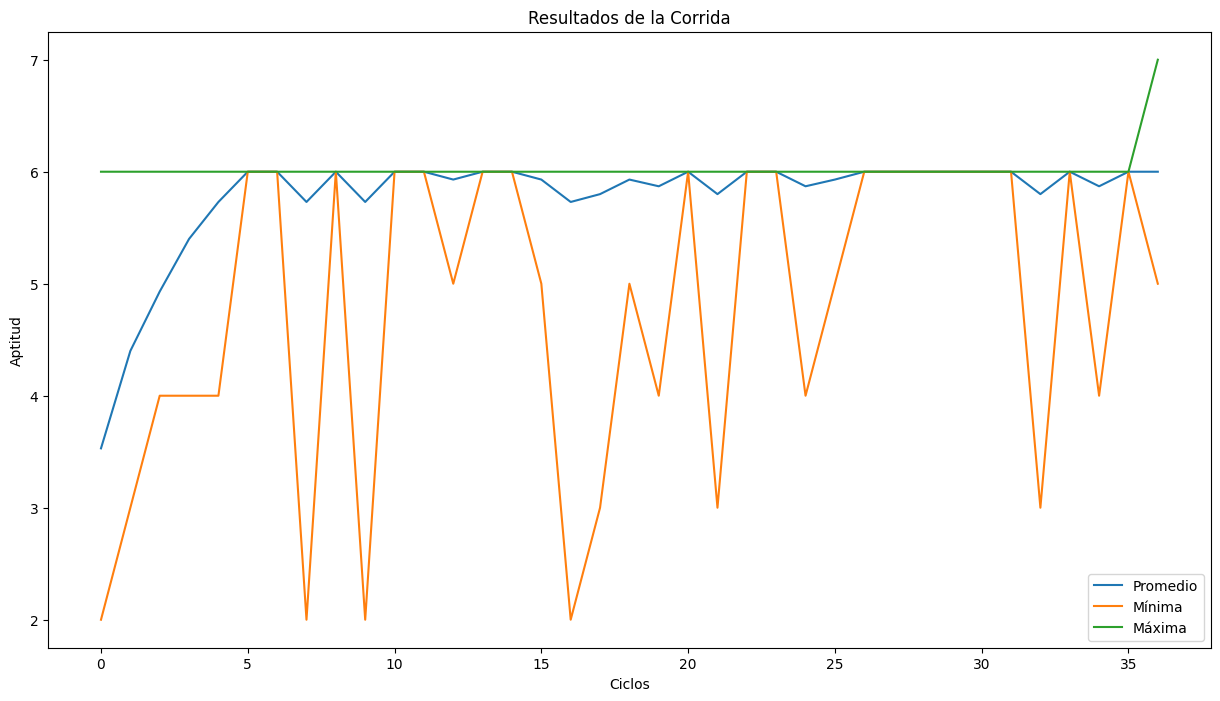

In [8]:
#@title MOSTRAR GRÁFICO DE LA CORRIDA
plt.figure(figsize=(15,8))
plt.plot(ciclosPromAptitud)
plt.plot(ciclosMinAptitud)
plt.plot(ciclosMaxAptitud)

plt.title('Resultados de la Corrida')
plt.xlabel('Ciclos')
plt.ylabel('Aptitud')
plt.legend(['Promedio', 'Mínima', 'Máxima'], loc='lower right')

plt.show()

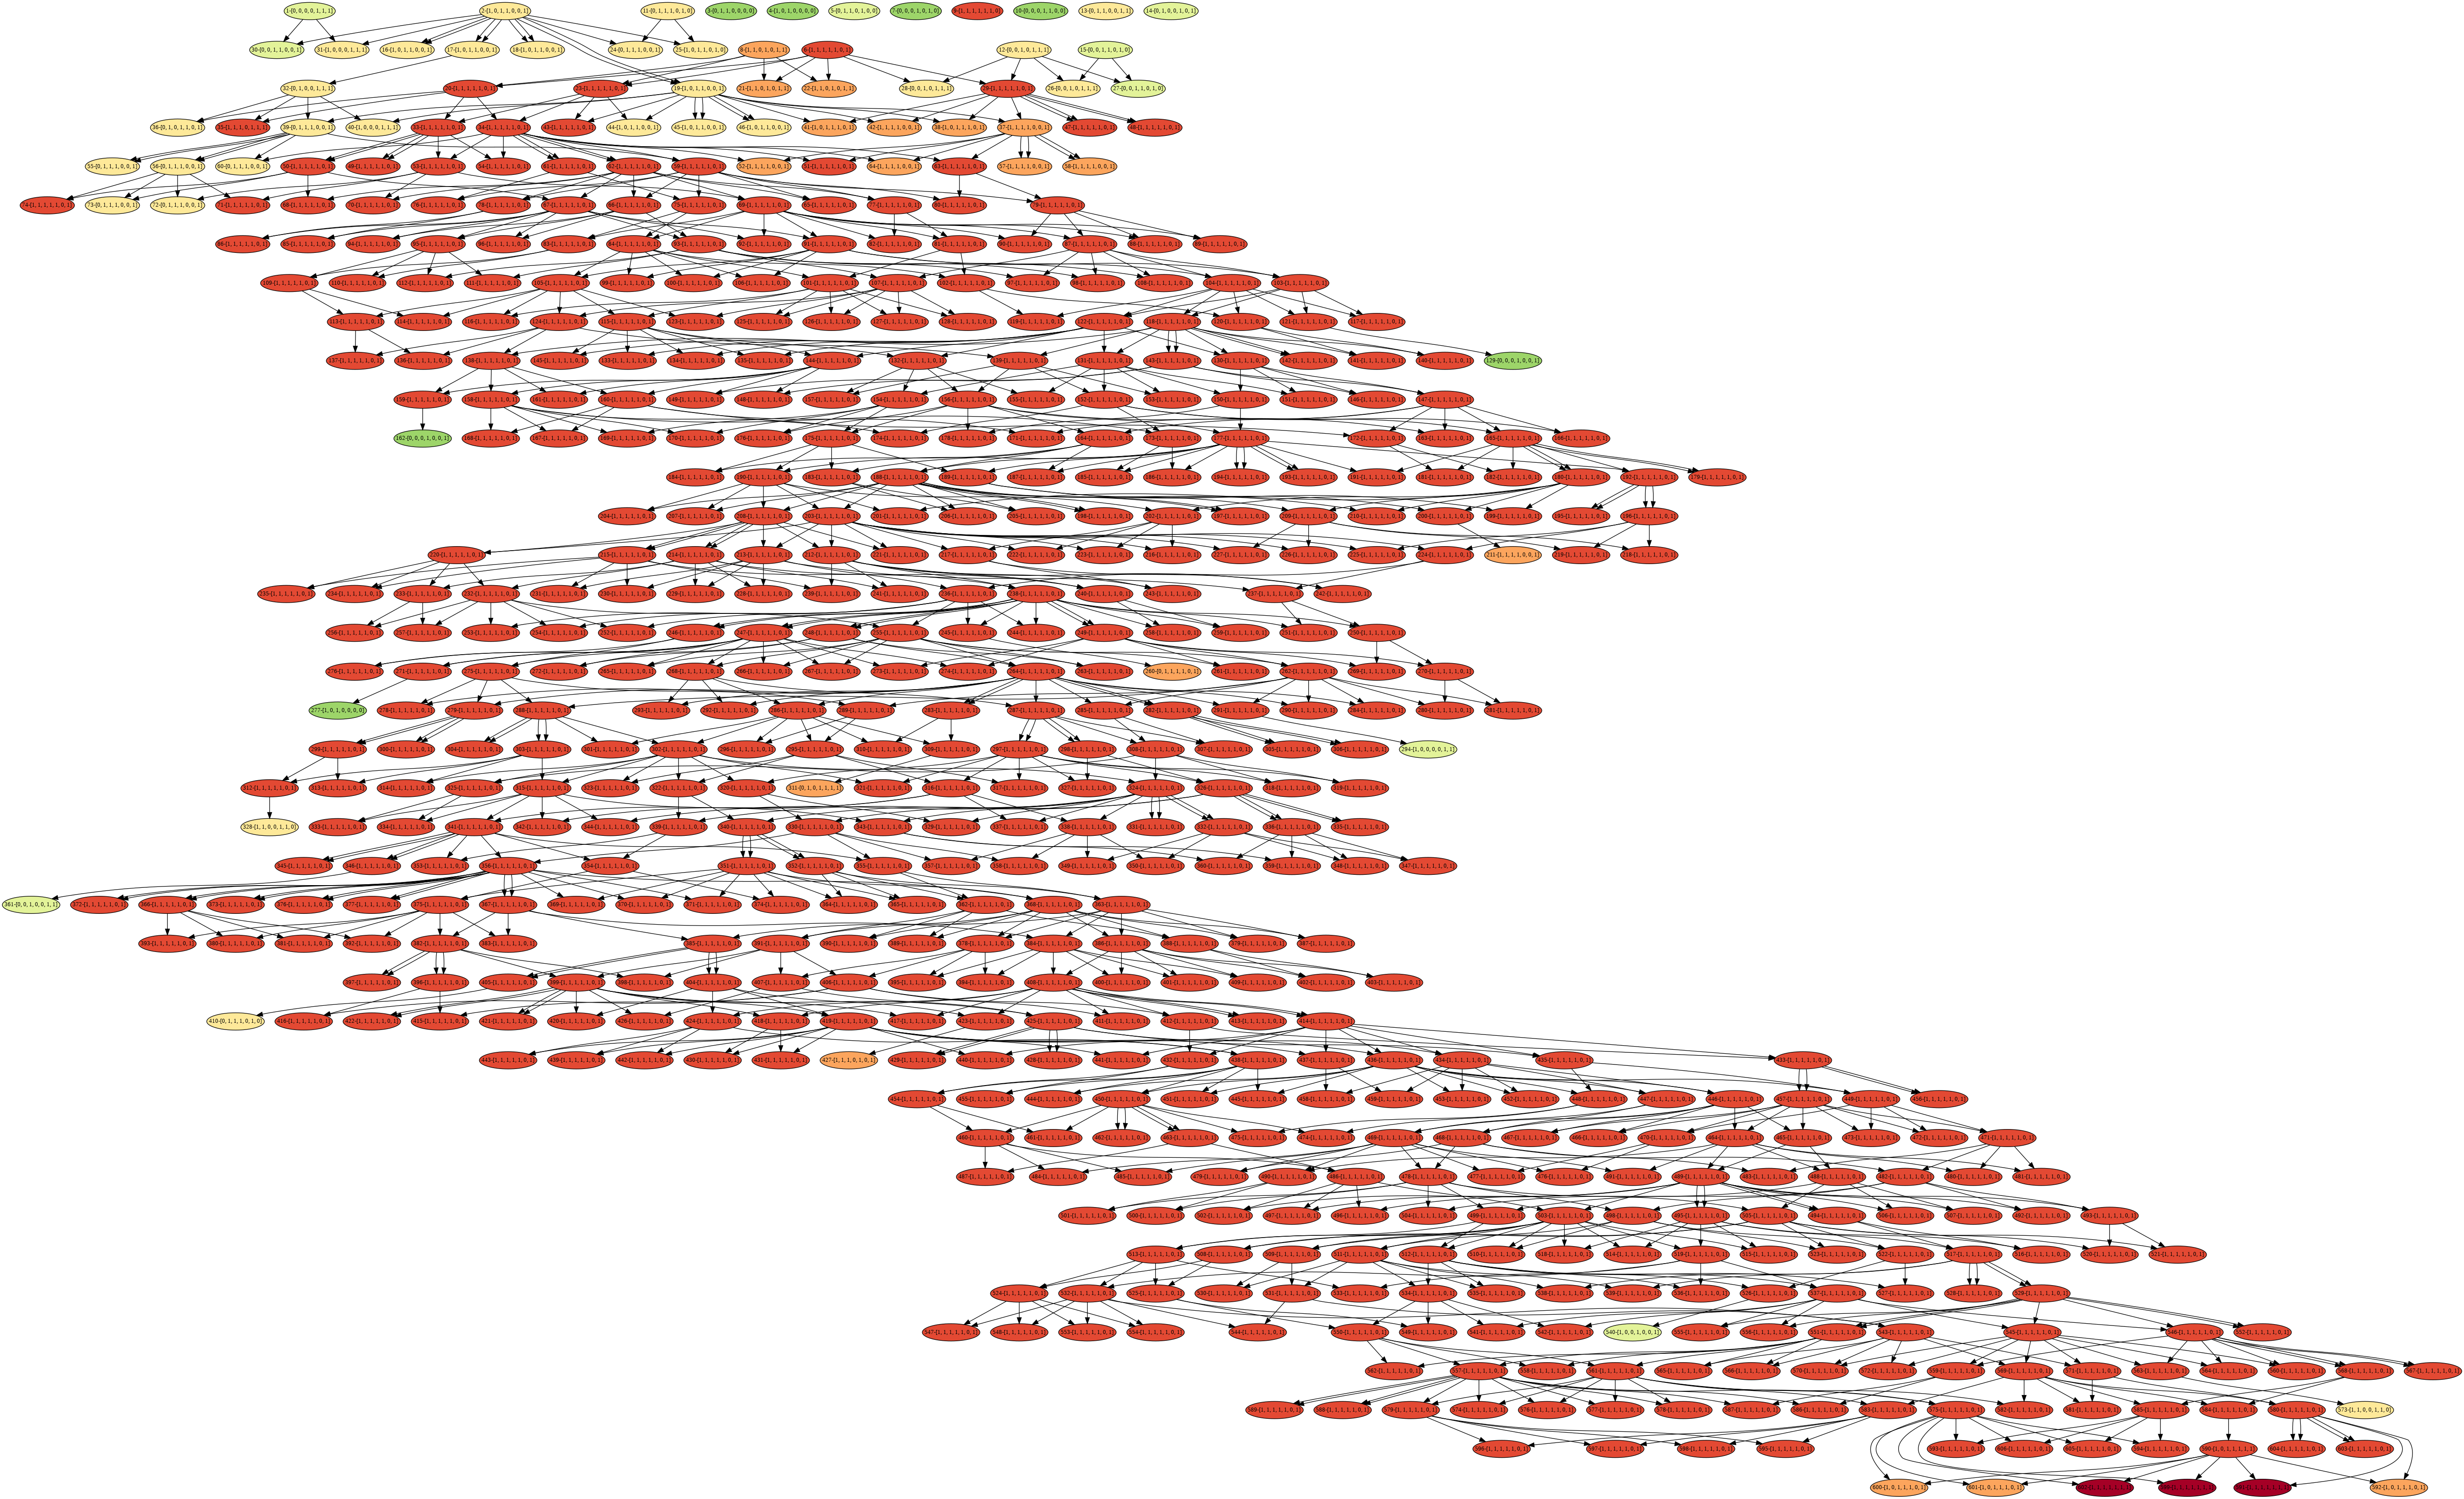

In [9]:
#@title MOSTRAR ÁRBOL GENEALÓGICO

incluir_Id_Individuo = True #@param {type:"boolean"}
pintar_Color_Aptitud = True #@param {type:"boolean"}
#@markdown (si se activa: color más ROJO significa PEOR aptitud, y más VERDE es MEJOR aptitud)

# genera gráfico
graph = networkx.MultiDiGraph(history.genealogy_tree)
graph = graph.reverse()     # Make the graph top-down

# cambia ID de individuos por detalle cromosoma
indHistory = {}
indApt = {}
for k in history.genealogy_history.keys():
  if incluir_Id_Individuo:
    auxStrLabel = str(k)+"-"+str(history.genealogy_history[k])
  else:
    auxStrLabel = str(history.genealogy_history[k])
  indHistory[k] = auxStrLabel
  if pintar_Color_Aptitud:
    indApt[auxStrLabel] = toolbox.evaluate(history.genealogy_history[k])[0]
graph = networkx.relabel_nodes(graph, indHistory)

# muestra como árbol
A = networkx.nx_agraph.to_agraph(graph)

# cambia colores por valor de aptitud
if pintar_Color_Aptitud:
  # determina mapa colores y valores mínimos/máximos
  cmap = matplotlib.colormaps.get_cmap('RdYlGn_r')
  ## para usar cuando no se conoce mín y/o max
  ##kMax= max(indApt.keys(), key=(lambda new_k: indApt[new_k]))
  ##kMin = min(indApt.keys(), key=(lambda new_k: indApt[new_k]))
  ##norm = matplotlib.colors.Normalize(vmin=indApt[kMin], vmax=indApt[kMax])
  norm = matplotlib.colors.Normalize(vmin=0, vmax=(cant_genesCromosoma*valorMax_genesCromosomas))
  # indica cambia color del nodo
  A.node_attr['style']='filled'
  for k in A.nodes():
      # obtiene el nodo
      n =  A.get_node(k)
      if k in indApt:
        # a partir de la aptitud asigna el color
        color = cmap(norm(indApt[k]))
        # asigna en format HEX
        n.attr['fillcolor'] =  matplotlib.colors.rgb2hex(color)

# define layout del gráfico
A.layout('dot', args='-Nfontsize=10 -Nwidth="1.0" -Nheight=".4" -Nmargin=0 -Gfontsize=8')

# muestra el gráfico
auxFile = '/content/genHistory.png'
A.draw(auxFile)

try:
  display(Image.open(auxFile))
except:
  print("-- No se puede mostrar la imagen ", auxFile, " por su tamaño, intente descargarla:")
  from google.colab import files
  files.download(auxFile)

